In [1]:
# Import necessary libraries
import numpy as np
import pyedflib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

In [2]:
import mne

# Load the data
raw = mne.io.read_raw_edf('Adult set/mesa-sleep-0074.edf')

# Print out all available channel indices
print("Available channel indices:")
for i, ch_name in enumerate(raw.ch_names):
    print(f"Index {i}: {ch_name}")

Extracting EDF parameters from /Users/honesty/Desktop/Sunday/all_works/ecg/Adult set/mesa-sleep-0074.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Available channel indices:
Index 0: EKG
Index 1: EOG-L
Index 2: EOG-R
Index 3: EMG
Index 4: EEG1
Index 5: EEG2
Index 6: EEG3
Index 7: Pres
Index 8: Flow
Index 9: Snore
Index 10: Thor
Index 11: Abdo
Index 12: Leg
Index 13: Therm
Index 14: Pos
Index 15: EKG_Off
Index 16: EOG-L_Off
Index 17: EOG-R_Off
Index 18: EMG_Off
Index 19: EEG1_Off
Index 20: EEG2_Off
Index 21: EEG3_Off
Index 22: Pleth
Index 23: OxStatus
Index 24: SpO2
Index 25: HR
Index 26: DHR


In [4]:
import tensorflow as tf
if tf.config.list_physical_devices('GPU'):
    print('GPU is available')
else:
    print('GPU is not available')

GPU is not available


In [7]:
# Read EDF files and extract the "Pleth" channel
def load_data(filename):
    with pyedflib.EdfReader(filename) as f:
        pleth_index = f.getSignalLabels().index("Pleth")
        pleth_data = f.readSignal(pleth_index)
    return pleth_data

In [10]:
# # Load data for adult and child datasets
# adult_data = load_data("Adult set/mesa-sleep-0056.edf")
# child_data = load_data("Child set/chat-baseline-300031.edf")

In [9]:
# Load data for adult and child datasets
adult_data = [load_data("Adult set/mesa-sleep-0056.edf"), load_data("Adult set/mesa-sleep-0074.edf")]
child_data = [load_data("Child set/chat-baseline-300031.edf"), load_data("Child set/chat-baseline-300036.edf")]

# REschape for modelling
adult_data_processed = [data.reshape(-1, 1) for data in adult_data]
child_data_processed = [data.reshape(-1, 1) for data in child_data]

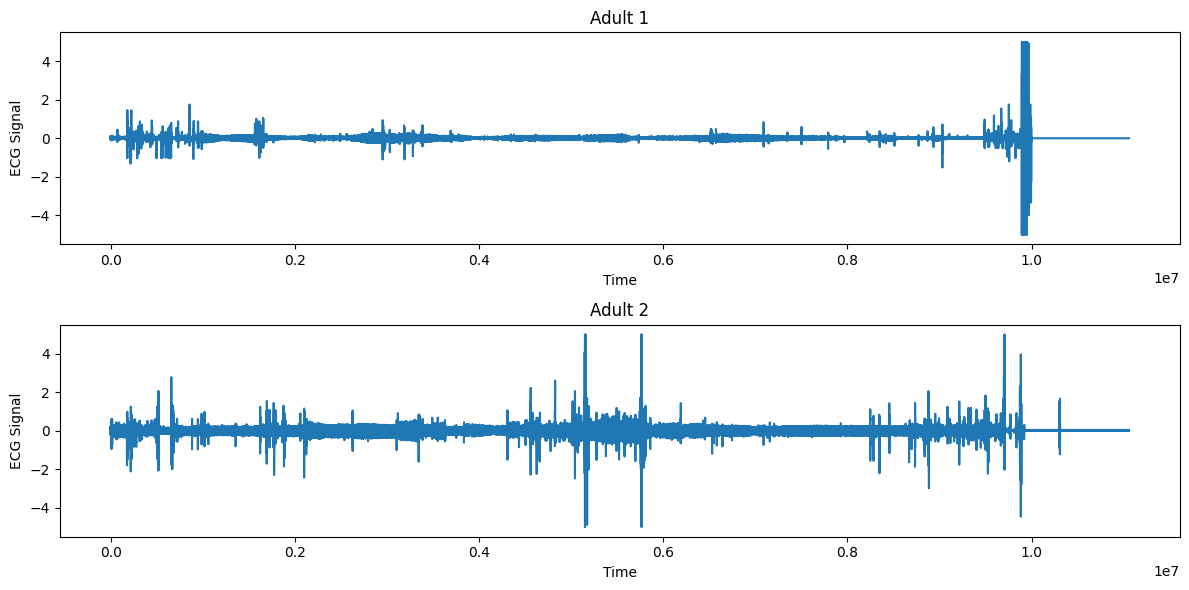

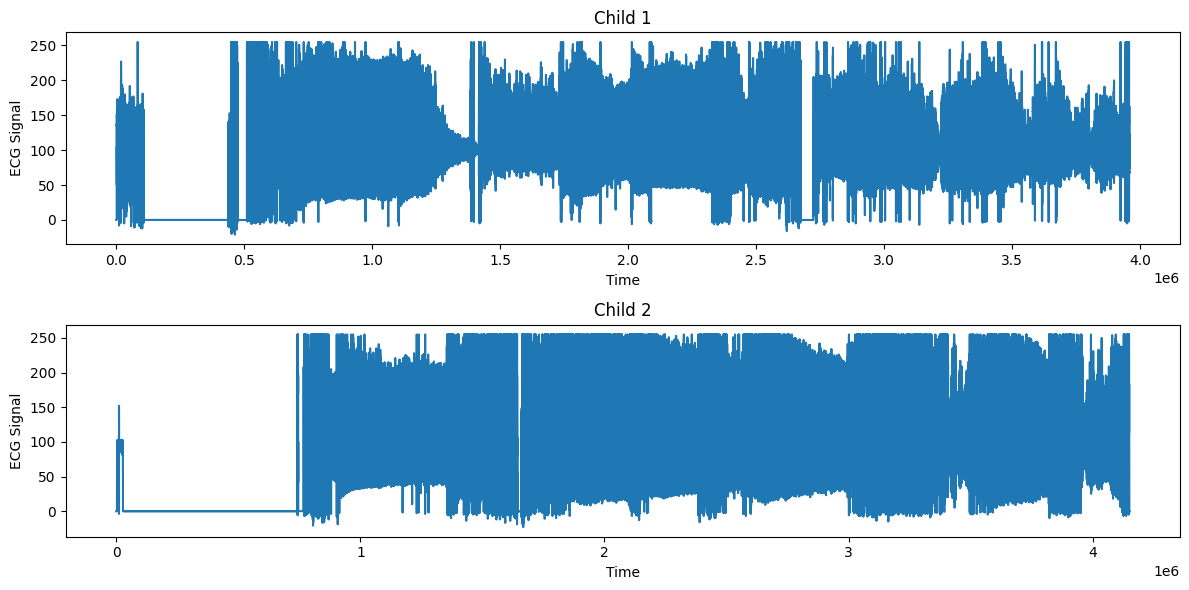

In [10]:
# Function to plot ECG signals
def plot_ecg_signals(signals, titles):
    plt.figure(figsize=(12, 6))
    for i, signal in enumerate(signals):
        plt.subplot(len(signals), 1, i+1)
        plt.plot(signal)
        plt.title(titles[i])
        plt.xlabel('Time')
        plt.ylabel('ECG Signal')
    plt.tight_layout()
    plt.show()

# Plot ECG signals for adult dataset
plot_ecg_signals(adult_data, ['Adult 1', 'Adult 2'])

# Plot ECG signals for child dataset
plot_ecg_signals(child_data, ['Child 1', 'Child 2'])

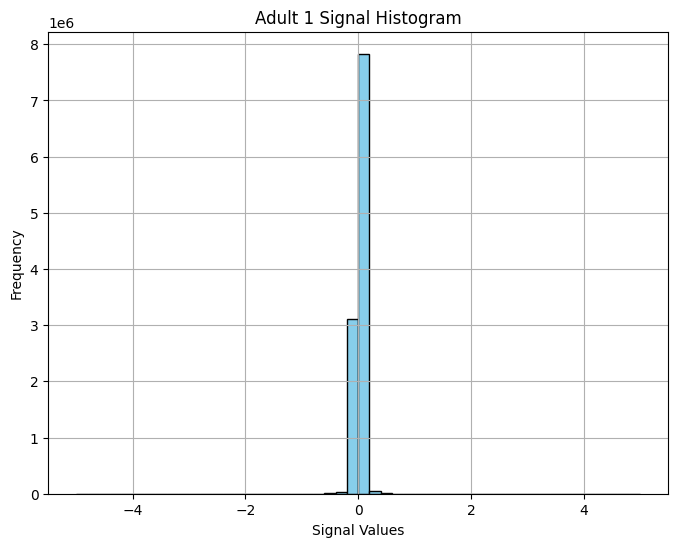

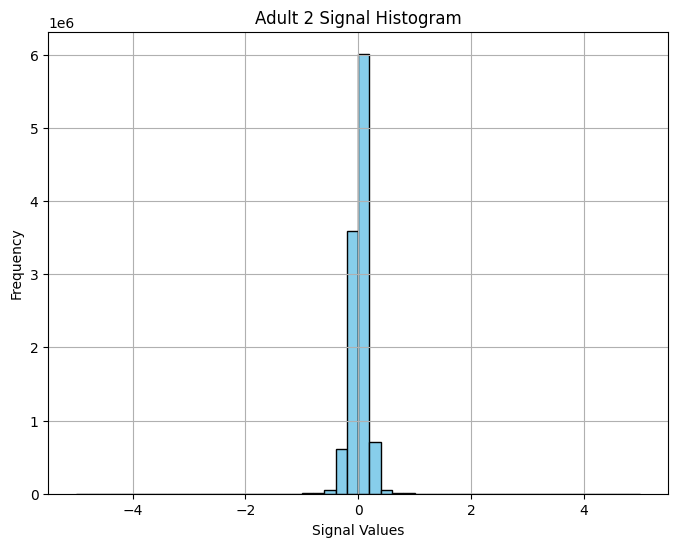

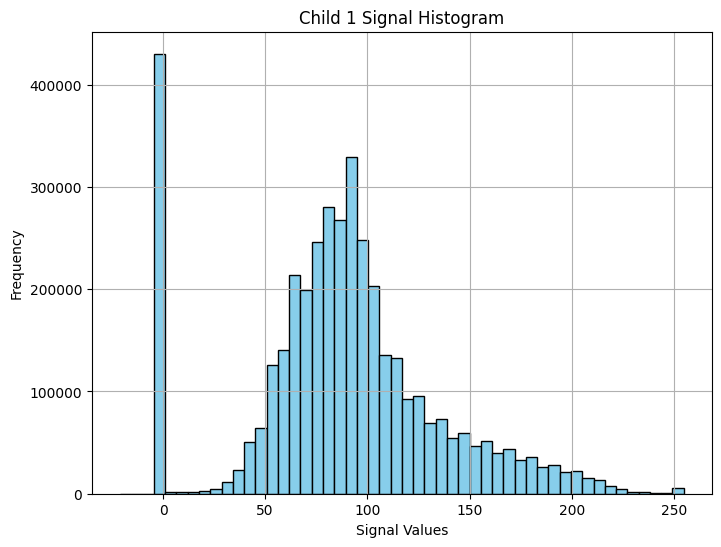

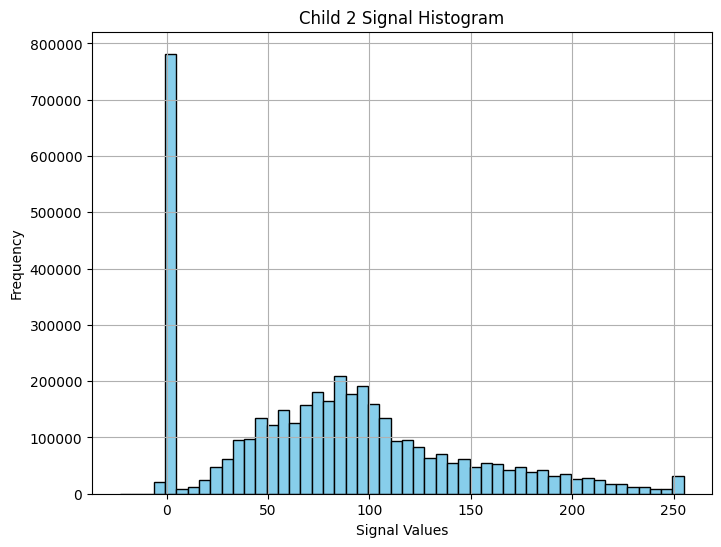

In [11]:
# Function to plot histogram of signal values
def plot_signal_histogram(signal_data, title):
    plt.figure(figsize=(8, 6))
    plt.hist(signal_data, bins=50, color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel('Signal Values')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Plot histogram of signal values for adult dataset
for i, signal_data in enumerate(adult_data):
    plot_signal_histogram(signal_data, f'Adult {i+1} Signal Histogram')

# Plot histogram of signal values for child dataset
for i, signal_data in enumerate(child_data):
    plot_signal_histogram(signal_data, f'Child {i+1} Signal Histogram')

In [23]:
from scipy.stats import skew

# Function to calculate descriptive statistics of signal data
def calculate_statistics(signal_data):
    mean_value = np.mean(signal_data)
    median_value = np.median(signal_data)
    std_deviation = np.std(signal_data)
    skewness = skew(signal_data)
    return mean_value, median_value, std_deviation, skewness


# for adult_data set 1 
mean_value, median_value, std_deviation, skewness = calculate_statistics(adult_data[0])
print("Mean:", mean_value)
print("Median:", median_value)
print("Standard Deviation:", std_deviation)
print("Skewness:", skewness)

Mean: 0.015520316605237184
Median: 0.012741283283741512
Standard Deviation: 0.10014421110348413
Skewness: 2.9379884761963386


In [24]:
# for adult_data set 2 
mean_value, median_value, std_deviation, skewness = calculate_statistics(adult_data[1])
print("Mean:", mean_value)
print("Median:", median_value)
print("Standard Deviation:", std_deviation)
print("Skewness:", skewness)

Mean: 0.018015318998016016
Median: 0.013656824597543298
Standard Deviation: 0.15150408856972347
Skewness: 0.7597919430192444


In [25]:
# for child_data set 1 
mean_value, median_value, std_deviation, skewness = calculate_statistics(child_data[0])
print("Mean:", mean_value)
print("Median:", median_value)
print("Standard Deviation:", std_deviation)
print("Skewness:", skewness)

Mean: 88.34620975486486
Median: 87.79999999999964
Standard Deviation: 47.305090694221825
Skewness: 0.17430469426044112


In [29]:
# for adult_data set 2
mean_value, median_value, std_deviation, skewness = calculate_statistics(child_data[1])
print("Mean:", mean_value)
print("Median:", median_value)
print("Standard Deviation:", std_deviation)
print("Skewness:", skewness)

Mean: 81.02416141001845
Median: 78.99999999999964
Standard Deviation: 60.501363489800596
Skewness: 0.5174253775796142


In [19]:
from scipy.signal import find_peaks, correlate

# Function to detect signal peaks and troughs
def detect_peaks_troughs(signal_data):
    peaks, _ = find_peaks(signal_data, height=0)  # Detect peaks
    troughs, _ = find_peaks(-signal_data, height=0)  # Detect troughs
    return peaks, troughs


peaks, troughs = detect_peaks_troughs(adult_data[0])  # Assuming adult_data[0] is the first signal in the adult dataset
print("Peaks:", peaks)
print("Troughs:", troughs)



Peaks: [     112      163      247 ... 10000227 10000231 10000235]
Troughs: [      30      216      256 ... 10000224 10000229 10000233]


In [20]:
# Function to perform frequency analysis
def frequency_analysis(signal_data, sampling_rate):
    fft_result = np.fft.fft(signal_data)  # Perform FFT
    frequencies = np.fft.fftfreq(len(signal_data), 1 / sampling_rate)  # Compute frequencies
    return frequencies, np.abs(fft_result)


sampling_rate = 1000  # Assuming sampling rate is 1000 Hz
frequencies, fft_result = frequency_analysis(adult_data[0], sampling_rate)
print("Frequencies:", frequencies)
print("FFT Result:", fft_result)

Frequencies: [ 0.00000000e+00  9.04245469e-05  1.80849094e-04 ... -2.71273641e-04
 -1.80849094e-04 -9.04245469e-05]
FFT Result: [171638.31219959  33520.24647557  26372.87086288 ...  16599.89963549
  26372.87086288  33520.24647557]


In [21]:
# Function to perform correlation analysis
def correlation_analysis(signal_data1, signal_data2):
    correlation_result = correlate(signal_data1, signal_data2, mode='same')  # Compute cross-correlation
    return correlation_result


correlation_result = correlation_analysis(adult_data[0], child_data[0])  # comparing the first signals of adult and child datasets
print("Correlation Result:", correlation_result)

Correlation Result: [2823057.97641717 2823929.5367132  2824777.12540626 ...  288559.41801327
  291310.08280308  293518.03968108]
